# JET Model Project

This Notebook is for the models testing. First we will try one basic hand made model, afer we will try transfer learning with existing models and fine tuning on them. And we will compare the reslults for evaluation and finally choose the best.

## 📌 1 - Loading data

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
tf.__version__

'2.19.0'

In [2]:
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=90,
                                                                brightness_range=(0.5,1), 
                                                                shear_range=0.2, 
                                                                channel_shift_range=0.2,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                zoom_range=0.2,
                                                                rescale=1./255,
                                                                validation_split=0.2)

In [3]:
img_generator_flow_train = img_generator.flow_from_directory(
    directory="Data_tyres",
    target_size=(224, 224),
    class_mode = "binary",
    batch_size=16,
    shuffle=True,
    subset="training")

img_generator_flow_valid = img_generator.flow_from_directory(
    directory="Data_tyres",
    target_size=(224, 224),
    class_mode = "binary",
    batch_size=16,
    shuffle=False,
    subset="validation")

Found 1486 images belonging to 2 classes.
Found 370 images belonging to 2 classes.


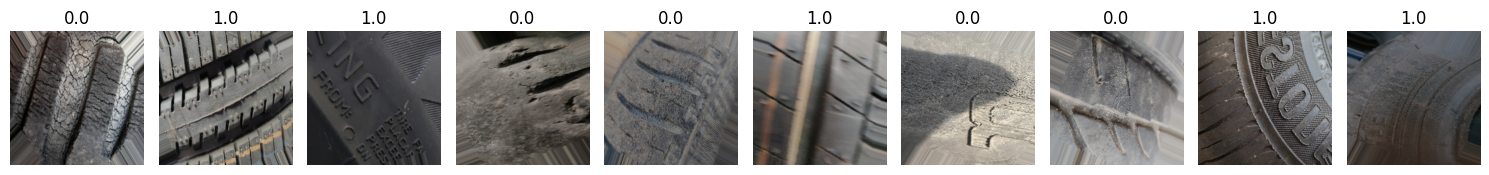

In [4]:
imgs, targets = next(iter(img_generator_flow_train))

# Nombre d'images à afficher
num_images_to_display = 10  # Vous pouvez ajuster ce nombre selon vos besoins

# Créer une figure avec une seule ligne
fig, ax = plt.subplots(1, num_images_to_display, figsize=(15, 5))

# Parcourir les images et les étiquettes
for i in range(num_images_to_display):
    ax[i].imshow(imgs[i])
    ax[i].set_title(str(targets[i]))
    ax[i].axis('off')  # Désactiver les axes pour une meilleure visualisation

# Afficher la figure
plt.tight_layout()
plt.show()

In [4]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, F1Score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## 📌 2 - Transfer Learning

### 🤖 InceptionV3

In [53]:
inception_model = tf.keras.applications.InceptionV3(input_shape=(224,224,3),
                                               include_top=False,
                                               weights = "imagenet"
                                               )

inception_model.trainable = False

In [54]:
model_inception = Sequential([
    inception_model,
    tf.keras.layers.GlobalAveragePooling2D(),  
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),  
    tf.keras.layers.Dropout(0.5),  # avoiding l'overfitting
    tf.keras.layers.Dense(1, activation="sigmoid")  # Binary Classification
])

In [56]:
model_inception.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,360,353 (85.30 MB)

 Trainable params: 557,569 (2.13 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [57]:
model_inception.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5)])

In [58]:
model_inception.fit(img_generator_flow_train, validation_data=img_generator_flow_valid, epochs=30)

Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 301s 3s/step - binary_accuracy: 0.5457 - loss: 0.7381 - val_binary_accuracy: 0.6162 - val_loss: 0.6564
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 241s 3s/step - binary_accuracy: 0.6389 - loss: 0.6801 - val_binary_accuracy: 0.6892 - val_loss: 0.6192
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - binary_accuracy: 0.7018 - loss: 0.5782 - val_binary_accuracy: 0.6865 - val_loss: 0.6079
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 256s 3s/step - binary_accuracy: 0.7107 - loss: 0.5633 - val_binary_accuracy: 0.7135 - val_loss: 0.5761
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - binary_accuracy: 0.7486 - loss: 0.5320 - val_binary_accuracy: 0.7189 - val_loss: 0.5781
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - binary_accuracy: 0.7849 - loss: 0.4804 - val_binary_accuracy: 0.7514 - val_loss: 0.5422
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 233s 3s/step - binary_accuracy: 0.7663 - loss: 0.4866 - val_binary_accuracy: 0.7108 - val_loss: 0.5478
Epoch 8/30
93

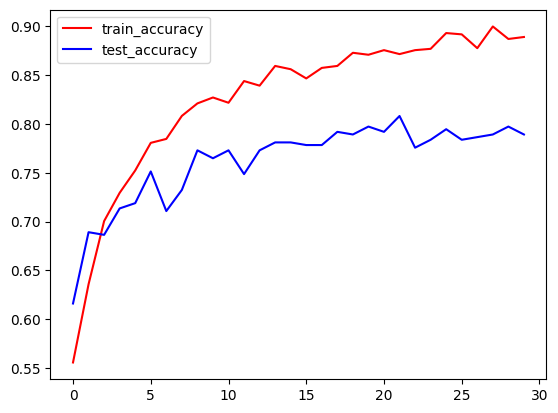

In [59]:
# Visualise train / Valid Accuracy
plt.plot(model_inception.history.history["binary_accuracy"], c="r", label="train_accuracy")
plt.plot(model_inception.history.history["val_binary_accuracy"], c="b", label="test_accuracy")
plt.legend()
plt.show()

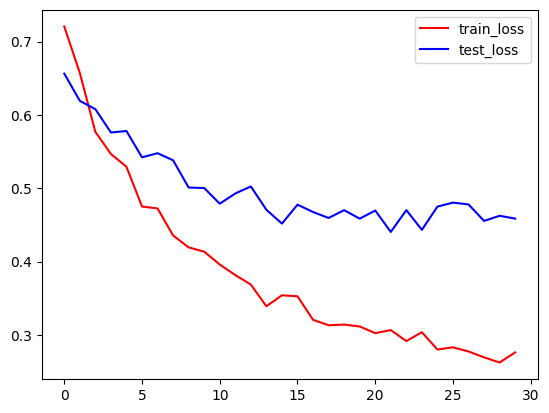

In [60]:
# Visualise train / Valid Accuracy
plt.plot(model_inception.history.history["loss"], c="r", label="train_loss")
plt.plot(model_inception.history.history["val_loss"], c="b", label="test_loss")
plt.legend()
plt.show()

In [65]:
model_inception.save("inceptionV3model.h5")

In [66]:
import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = model_inception.history.history
# Save it under the form of a json file
json.dump(history_dict, open("inceptionV3modelHistory.json", 'w'))

### 🤖 - MobileNet

In [8]:
mobilnet_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights = "imagenet"
                                               )

mobilnet_model.trainable = False

In [53]:
model_mobilnet = Sequential([
    mobilnet_model,
    tf.keras.layers.GlobalAveragePooling2D(),  
    tf.keras.layers.Dense(256, activation="relu"),  
    tf.keras.layers.Dropout(0.5),  # Évite l'overfitting
    tf.keras.layers.Dense(1, activation="sigmoid")  # Classification binaire
])

In [54]:
model_mobilnet.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,177 (9.87 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [55]:
model_mobilnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [56]:
model_mobilnet.fit(img_generator_flow_train, validation_data=img_generator_flow_valid, epochs=20)

Epoch 1/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - binary_accuracy: 0.6598 - loss: 0.7026 - val_binary_accuracy: 0.7811 - val_loss: 0.4670
Epoch 2/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 90s 972ms/step - binary_accuracy: 0.8300 - loss: 0.3969 - val_binary_accuracy: 0.8000 - val_loss: 0.4365
Epoch 3/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 92s 987ms/step - binary_accuracy: 0.8529 - loss: 0.3311 - val_binary_accuracy: 0.8108 - val_loss: 0.4069
Epoch 4/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 91s 979ms/step - binary_accuracy: 0.8678 - loss: 0.3077 - val_binary_accuracy: 0.8027 - val_loss: 0.4276
Epoch 5/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 91s 976ms/step - binary_accuracy: 0.8739 - loss: 0.2876 - val_binary_accuracy: 0.8243 - val_loss: 0.3781
Epoch 6/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 91s 981ms/step - binary_accuracy: 0.8729 - loss: 0.2736 - val_binary_accuracy: 0.8108 - val_loss: 0.3894
Epoch 7/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 90s 966ms/step - binary_accuracy: 0.8877 - loss: 0.2395 - val_binary_accuracy: 0.8270 - val_loss: 0.3850
Ep

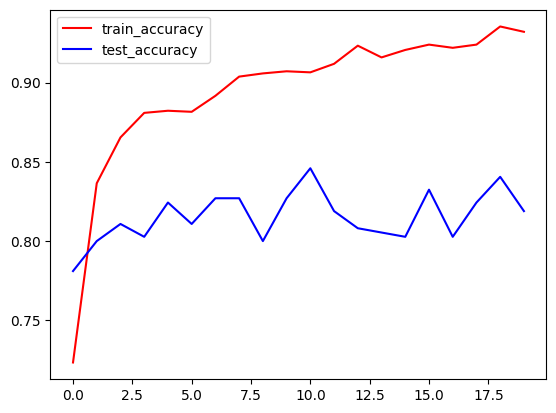

In [58]:
# Visualise train / Valid Accuracy
plt.plot(model_mobilnet.history.history["binary_accuracy"], c="r", label="train_accuracy")
plt.plot(model_mobilnet.history.history["val_binary_accuracy"], c="b", label="test_accuracy")
plt.legend()
plt.show()

In [59]:
model_mobilnet.save("mobilnetV2model.h5")

In [60]:
import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = model_mobilnet.history.history
# Save it under the form of a json file
json.dump(history_dict, open("mobiltnetV2modelHistory.json", 'w'))

In [46]:
model_mobilnet_2 = Sequential([
    mobilnet_model,
    tf.keras.layers.GlobalAveragePooling2D(),  
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),  
    tf.keras.layers.Dropout(0.5),  # avoiding l'overfitting
    tf.keras.layers.Dense(1, activation="sigmoid")  # Binary Classification
])

In [47]:
model_mobilnet_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5)])

In [48]:
model_mobilnet_2.fit(img_generator_flow_train, validation_data=img_generator_flow_valid, epochs=30)

c:\Users\youen\deep_tensorflow_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - binary_accuracy: 0.4895 - loss: 0.8569 - val_binary_accuracy: 0.6297 - val_loss: 0.6589
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - binary_accuracy: 0.5631 - loss: 0.7127 - val_binary_accuracy: 0.7189 - val_loss: 0.5985
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - binary_accuracy: 0.6287 - loss: 0.6460 - val_binary_accuracy: 0.7270 - val_loss: 0.5822
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - binary_accuracy: 0.6868 - loss: 0.5709 - val_binary_accuracy: 0.7595 - val_loss: 0.5528
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - binary_accuracy: 0.7393 - loss: 0.5119 - val_binary_accuracy: 0.7378 - val_loss: 0.5389
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - binary_accuracy: 0.7551 - loss: 0.4928 - val_binary_accuracy: 0.7486 - val_loss: 0.5235
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - binary_accuracy: 0.7727 - loss: 0.4792 - val_binary_accuracy: 0.7432 - val_loss: 0.5050
Epoch 8/30
93

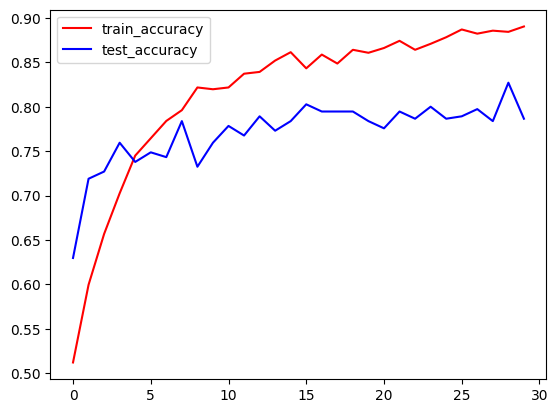

In [49]:
# Visualise train / Valid Accuracy
plt.plot(model_mobilnet_2.history.history["binary_accuracy"], c="r", label="train_accuracy")
plt.plot(model_mobilnet_2.history.history["val_binary_accuracy"], c="b", label="test_accuracy")
plt.legend()
plt.show()

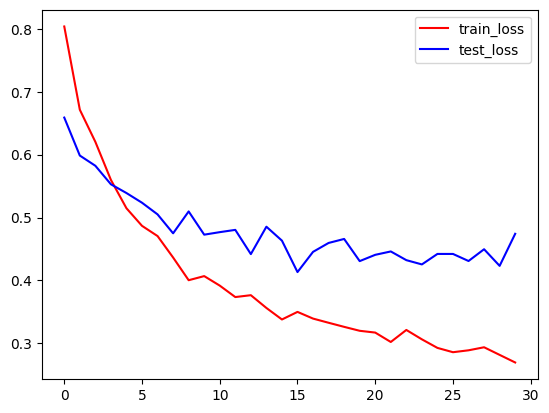

In [50]:
# Visualise train / Valid Accuracy
plt.plot(model_mobilnet_2.history.history["loss"], c="r", label="train_loss")
plt.plot(model_mobilnet_2.history.history["val_loss"], c="b", label="test_loss")
plt.legend()
plt.show()

In [13]:
model_mobilnet_2.save("mobilnetV2_2_model.h5")

In [14]:
import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = model_mobilnet_2.history.history
# Save it under the form of a json file
json.dump(history_dict, open("mobiltnetV2_2_modelHistory.json", 'w'))

### 🔮 - Tests for predictions

With MobileNetV2

In [51]:
y_pred_test = model_mobilnet_2.predict(img_generator_flow_valid)
y_pred_test = (y_pred_test > 0.5).astype(int).flatten()  # Convertion in 0/1


24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 978ms/step


In [ ]:
y_pred_test

array([0, 1, 1, ..., 0, 0, 0])

In [ ]:
img_generator_flow_valid.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

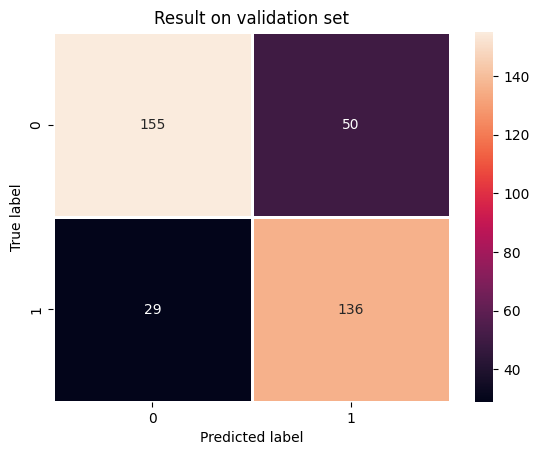

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mtx = confusion_matrix(img_generator_flow_valid.classes, y_pred_test)
sns.heatmap(mtx, annot=True, fmt='d', linewidths=.8)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Result on validation set')
plt.show()


In [16]:
mobilnet_load = tf.keras.models.load_model("mobilnetV2_2_model.h5")

In [17]:
y_pred = mobilnet_load.predict(img_generator_flow_valid)

24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 677ms/step


With InceptionV3

In [63]:
y_pred_test = model_inception.predict(img_generator_flow_valid)
y_pred_test = (y_pred_test > 0.5).astype(int).flatten()  # Convertion in 0/1


24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 817ms/step


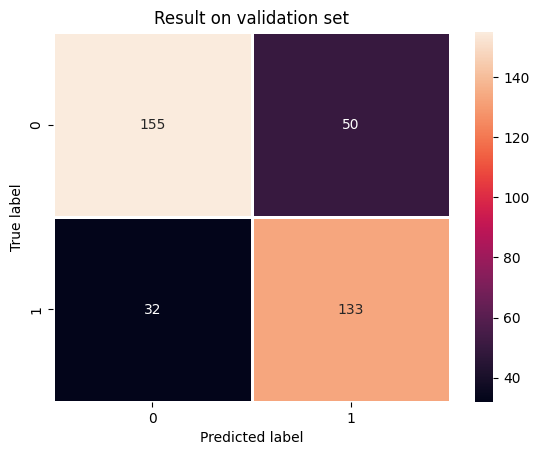

In [64]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mtx = confusion_matrix(img_generator_flow_valid.classes, y_pred_test)
sns.heatmap(mtx, annot=True, fmt='d', linewidths=.8)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Result on validation set')
plt.show()


In [6]:
tf.keras.utils.get_file("inceptionV3model_hug.h5",
                        origin="https://huggingface.co/HyraXuna/JET_model_inceptionV3_base/resolve/main/inceptionV3model.h5",
                        cache_subdir='models')

'C:\\Users\\youen\\.keras\\models\\inceptionV3model_hug.h5'

In [7]:
model_loaded = tf.keras.models.load_model("C:\\Users\\youen\\.keras\\datasets\\inceptionV3model_hug.h5")

In [12]:
y_pred_test = model_loaded.predict(img_generator_flow_valid[0])
y_pred_test = (y_pred_test > 0.5).astype(int).flatten()  # Convertion in 0/1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


In [13]:
y_pred_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

## 📌3 - Fine tuning

In [12]:
inception_model = tf.keras.applications.InceptionV3(input_shape=(224,224,3),
                                               include_top=False,
                                               weights = "imagenet"
                                               )

inception_model.trainable = True
for layer in inception_model.layers[:-20]:  # Débloque seulement les 10 dernières couches
    layer.trainable = False

In [13]:
model_inception_fine_tune = Sequential([
    inception_model,
    tf.keras.layers.GlobalAveragePooling2D(),  
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.BatchNormalization(),  # Ajout d'une normalisation
    tf.keras.layers.Dense(128, activation="relu"),  
    tf.keras.layers.Dropout(0.5),  
    tf.keras.layers.Dense(1, activation="sigmoid")  
])

In [14]:
model_inception_fine_tune.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_189         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,361,377 (85.30 MB)

 Trainable params: 2,493,441 (9.51 MB)

 Non-trainable params: 19,867,936 (75.79 MB)

In [15]:
model_inception_fine_tune.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5)])

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-7, verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrique à surveiller
    patience=10,          # Nombre d'époques à attendre après amélioration
    restore_best_weights=True  # Restaurer les meilleurs poids observés
)

checkpoint_callback = ModelCheckpoint(filepath="C:/Users/youen/Desktop/Formation_Perso/Jedha/Data_science/Projet_final/ckpt/model_epoch_{epoch:02d}_val_acc_{val_binary_accuracy:.2f}.weights.h5", 
                                      monitor='val_binary_accuracy',  
                                      save_best_only=True,  # Sauvegarde uniquement si le modèle s'améliore
                                      save_weights_only=True,  # Sauvegarde tout le modèle (poids + architecture)
                                      mode='max',  # On veut maximiser la validation accuracy
                                      verbose=1)

In [16]:
model_inception_fine_tune.fit(img_generator_flow_train, validation_data=img_generator_flow_valid, epochs=40, callbacks=[early_stopping, checkpoint_callback])

Epoch 1/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.5742 - loss: 0.8023
Epoch 1: val_binary_accuracy improved from -inf to 0.59730, saving model to C:/Users/youen/Desktop/Formation_Perso/Jedha/Data_science/Projet_final/ckpt/model_epoch_01_val_acc_0.60.weights.h5
93/93 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - binary_accuracy: 0.5745 - loss: 0.8018 - val_binary_accuracy: 0.5973 - val_loss: 0.6739
Epoch 2/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.6706 - loss: 0.6520
Epoch 2: val_binary_accuracy improved from 0.59730 to 0.68919, saving model to C:/Users/youen/Desktop/Formation_Perso/Jedha/Data_science/Projet_final/ckpt/model_epoch_02_val_acc_0.69.weights.h5
93/93 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - binary_accuracy: 0.6709 - loss: 0.6515 - val_binary_accuracy: 0.6892 - val_loss: 0.6077
Epoch 3/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.7604 - loss: 0.5098
Epoch 3: val_binary_accuracy improved from 0.68919 to 0.70541, saving model to C:/Use

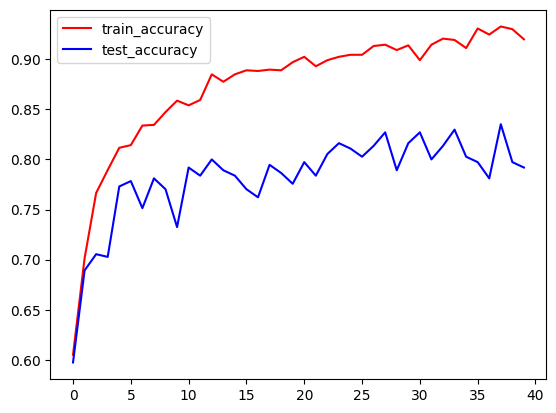

In [17]:
# Visualise train / Valid Accuracy
plt.plot(model_inception_fine_tune.history.history["binary_accuracy"], c="r", label="train_accuracy")
plt.plot(model_inception_fine_tune.history.history["val_binary_accuracy"], c="b", label="test_accuracy")
plt.legend()
plt.show()

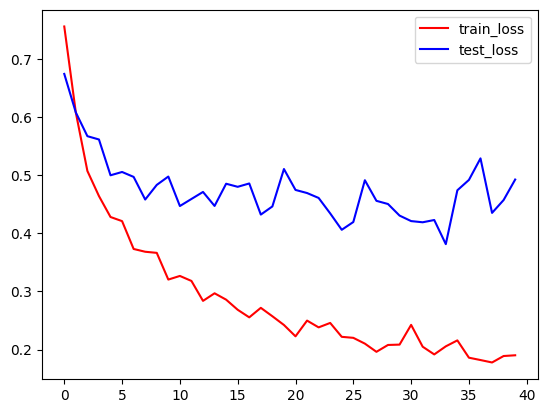

In [18]:
# Visualise train / Valid Accuracy
plt.plot(model_inception_fine_tune.history.history["loss"], c="r", label="train_loss")
plt.plot(model_inception_fine_tune.history.history["val_loss"], c="b", label="test_loss")
plt.legend()
plt.show()

In [19]:
model_inception_fine_tune.save("inceptionV3model_finetune.h5")

In [20]:
import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = model_inception_fine_tune.history.history
# Save it under the form of a json file
json.dump(history_dict, open("inceptionV3model_finetune_History.json", 'w'))

In [25]:
y_pred_test = model_inception_fine_tune.predict(img_generator_flow_valid)
y_pred_test = (y_pred_test > 0.5).astype(int).flatten()  # Convertion in 0/1


24/24 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step 


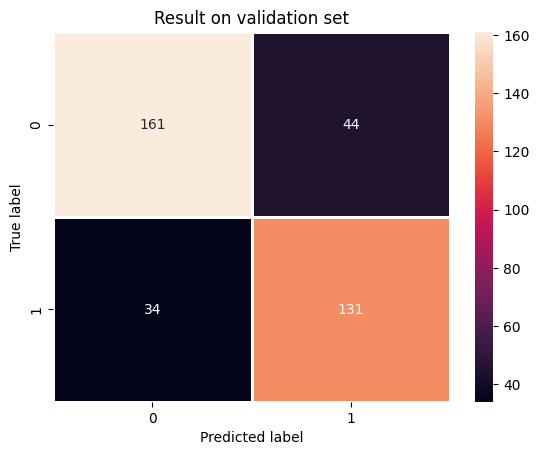

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mtx = confusion_matrix(img_generator_flow_valid.classes, y_pred_test)
sns.heatmap(mtx, annot=True, fmt='d', linewidths=.8)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Result on validation set')
plt.show()


mobilenet


In [5]:
mobilnet_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights = "imagenet"
                                               )

mobilnet_model.trainable = True
for layer in mobilnet_model.layers[:-10]:  # Débloque seulement les 10 dernières couches
    layer.trainable = False

In [6]:
mobilnet_model_fine_tune = Sequential([
    mobilnet_model,
    tf.keras.layers.GlobalAveragePooling2D(),  
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),  
    tf.keras.layers.Dropout(0.5),  # avoiding l'overfitting
    tf.keras.layers.Dense(1, activation="sigmoid")  # Binary Classification
])

In [7]:
mobilnet_model_fine_tune.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,618,945 (9.99 MB)

 Trainable params: 1,093,441 (4.17 MB)

 Non-trainable params: 1,525,504 (5.82 MB)

In [8]:
mobilnet_model_fine_tune.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5)])

early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrique à surveiller
    patience=5,          # Nombre d'époques à attendre après amélioration
    restore_best_weights=True  # Restaurer les meilleurs poids observés
)

checkpoint_callback = ModelCheckpoint(filepath="C:/Users/youen/Desktop/Formation_Perso/Jedha/Data_science/Projet_final/ckpt_mobilenet/model_epoch_{epoch:02d}_val_acc_{val_binary_accuracy:.2f}.h5", 
                                      monitor='val_binary_accuracy',  
                                      save_best_only=True,  # Sauvegarde uniquement si le modèle s'améliore
                                      save_weights_only=False,  # Sauvegarde tout le modèle (poids + architecture)
                                      mode='max',  # On veut maximiser la validation accuracy
                                      verbose=1)

In [9]:
mobilnet_model_fine_tune.fit(img_generator_flow_train, validation_data=img_generator_flow_valid, epochs=40, callbacks=[early_stopping, checkpoint_callback])

c:\Users\youen\deep_tensorflow_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.4784 - loss: 0.7681
Epoch 1: val_binary_accuracy improved from -inf to 0.64054, saving model to C:/Users/youen/Desktop/Formation_Perso/Jedha/Data_science/Projet_final/ckpt_mobilenet/model_epoch_01_val_acc_0.64.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 237s 3s/step - binary_accuracy: 0.4790 - loss: 0.7676 - val_binary_accuracy: 0.6405 - val_loss: 0.6539
Epoch 2/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.6686 - loss: 0.6159
Epoch 2: val_binary_accuracy improved from 0.64054 to 0.69730, saving model to C:/Users/youen/Desktop/Formation_Perso/Jedha/Data_science/Projet_final/ckpt_mobilenet/model_epoch_02_val_acc_0.70.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - binary_accuracy: 0.6686 - loss: 0.6158 - val_binary_accuracy: 0.6973 - val_loss: 0.5987
Epoch 3/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.7469 - loss: 0.5400
Epoch 3: val_binary_accuracy improved from 0.69730 to 0.72162, saving model to C:/Users/youen/Desktop/Formation_Perso/Jedha/Data_science/Projet_final/ckpt_mobilenet/model_epoch_03_val_acc_0.72.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - binary_accuracy: 0.7470 - loss: 0.5400 - val_binary_accuracy: 0.7216 - val_loss: 0.5460
Epoch 4/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 854ms/step - binary_accuracy: 0.7796 - loss: 0.4877
Epoch 4: val_binary_accuracy improved from 0.72162 to 0.76216, saving model to C:/Users/youen/Desktop/Formation_Perso/Jedha/Data_science/Projet_final/ckpt_mobilenet/model_epoch_04_val_acc_0.76.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - binary_accuracy: 0.7798 - loss: 0.4876 - val_binary_accuracy: 0.7622 - val_loss: 0.5069
Epoch 5/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 806ms/step - binary_accuracy: 0.7941 - loss: 0.4665
Epoch 5: val_binary_accuracy improved from 0.76216 to 0.77027, saving model to C:/Users/youen/Desktop/Formation_Perso/Jedha/Data_science/Projet_final/ckpt_mobilenet/model_epoch_05_val_acc_0.77.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 90s 970ms/step - binary_accuracy: 0.7942 - loss: 0.4663 - val_binary_accuracy: 0.7703 - val_loss: 0.5106
Epoch 6/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 844ms/step - binary_accuracy: 0.8443 - loss: 0.4030
Epoch 6: val_binary_accuracy did not improve from 0.77027
93/93 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - binary_accuracy: 0.8441 - loss: 0.4030 - val_binary_accuracy: 0.7568 - val_loss: 0.4966
Epoch 7/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - binary_accuracy: 0.8486 - loss: 0.3760
Epoch 7: val_binary_accuracy improved from 0.77027 to 0.78378, saving model to C:/Users/youen/Desktop/Formation_Perso/Jedha/Data_science/Projet_final/ckpt_mobilenet/model_epoch_07_val_acc_0.78.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 91s 983ms/step - binary_accuracy: 0.8486 - loss: 0.3760 - val_binary_accuracy: 0.7838 - val_loss: 0.4774
Epoch 8/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - binary_accuracy: 0.8543 - loss: 0.3672
Epoch 8: val_binary_accuracy improved from 0.78378 to 0.80541, saving model to C:/Users/youen/Desktop/Formation_Perso/Jedha/Data_science/Projet_final/ckpt_mobilenet/model_epoch_08_val_acc_0.81.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 90s 966ms/step - binary_accuracy: 0.8543 - loss: 0.3671 - val_binary_accuracy: 0.8054 - val_loss: 0.4447
Epoch 9/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 836ms/step - binary_accuracy: 0.8465 - loss: 0.3626
Epoch 9: val_binary_accuracy did not improve from 0.80541
93/93 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - binary_accuracy: 0.8466 - loss: 0.3625 - val_binary_accuracy: 0.7946 - val_loss: 0.4452
Epoch 10/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - binary_accuracy: 0.8578 - loss: 0.3400
Epoch 10: val_binary_accuracy did not improve from 0.80541
93/93 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - binary_accuracy: 0.8578 - loss: 0.3399 - val_binary_accuracy: 0.8054 - val_loss: 0.4614
Epoch 11/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 852ms/step - binary_accuracy: 0.8627 - loss: 0.3222
Epoch 11: val_binary_accuracy improved from 0.80541 to 0.82432, saving model to C:/Users/youen/Desktop/Formation_Perso/Jedha/Data_science/Projet_final/ckpt_mobilenet/model_epoch_11_val_acc_0.82.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - binary_accuracy: 0.8628 - loss: 0.3221 - val_binary_accuracy: 0.8243 - val_loss: 0.4268
Epoch 12/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 834ms/step - binary_accuracy: 0.8791 - loss: 0.2885
Epoch 12: val_binary_accuracy did not improve from 0.82432
93/93 ━━━━━━━━━━━━━━━━━━━━ 92s 992ms/step - binary_accuracy: 0.8791 - loss: 0.2886 - val_binary_accuracy: 0.8189 - val_loss: 0.4279
Epoch 13/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - binary_accuracy: 0.8694 - loss: 0.2997
Epoch 13: val_binary_accuracy did not improve from 0.82432
93/93 ━━━━━━━━━━━━━━━━━━━━ 91s 976ms/step - binary_accuracy: 0.8694 - loss: 0.2997 - val_binary_accuracy: 0.8108 - val_loss: 0.4266
Epoch 14/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 817ms/step - binary_accuracy: 0.8801 - loss: 0.2824
Epoch 14: val_binary_accuracy did not improve from 0.82432
93/93 ━━━━━━━━━━━━━━━━━━━━ 91s 978ms/step - binary_accuracy: 0.8800 - loss: 0.2825 - val_binary_accuracy: 0.8216 - val_loss: 0.4301
Epoch 15/40
93/9

93/93 ━━━━━━━━━━━━━━━━━━━━ 90s 967ms/step - binary_accuracy: 0.8768 - loss: 0.2795 - val_binary_accuracy: 0.8351 - val_loss: 0.4092
Epoch 16/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - binary_accuracy: 0.8817 - loss: 0.2882
Epoch 16: val_binary_accuracy improved from 0.83514 to 0.85946, saving model to C:/Users/youen/Desktop/Formation_Perso/Jedha/Data_science/Projet_final/ckpt_mobilenet/model_epoch_16_val_acc_0.86.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 90s 970ms/step - binary_accuracy: 0.8817 - loss: 0.2880 - val_binary_accuracy: 0.8595 - val_loss: 0.3904
Epoch 17/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 812ms/step - binary_accuracy: 0.8711 - loss: 0.2947
Epoch 17: val_binary_accuracy did not improve from 0.85946
93/93 ━━━━━━━━━━━━━━━━━━━━ 91s 973ms/step - binary_accuracy: 0.8711 - loss: 0.2945 - val_binary_accuracy: 0.8378 - val_loss: 0.4036
Epoch 18/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 808ms/step - binary_accuracy: 0.8939 - loss: 0.2627
Epoch 18: val_binary_accuracy did not improve from 0.85946
93/93 ━━━━━━━━━━━━━━━━━━━━ 90s 970ms/step - binary_accuracy: 0.8939 - loss: 0.2627 - val_binary_accuracy: 0.8405 - val_loss: 0.4050
Epoch 19/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - binary_accuracy: 0.8977 - loss: 0.2536
Epoch 19: val_binary_accuracy did not improve from 0.85946
93/93 ━━━━━━━━━━━━━━━━━━━━ 92s 987ms/step - binary_accuracy: 0.8977 - loss: 0.2536 - val_binary_accuracy: 0.8081 - val_loss: 0.4084
Epoch 20/40
9

93/93 ━━━━━━━━━━━━━━━━━━━━ 91s 974ms/step - binary_accuracy: 0.8952 - loss: 0.2461 - val_binary_accuracy: 0.8622 - val_loss: 0.3480
Epoch 24/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - binary_accuracy: 0.9001 - loss: 0.2353
Epoch 24: val_binary_accuracy did not improve from 0.86216
93/93 ━━━━━━━━━━━━━━━━━━━━ 91s 981ms/step - binary_accuracy: 0.9001 - loss: 0.2353 - val_binary_accuracy: 0.8297 - val_loss: 0.3598
Epoch 25/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 821ms/step - binary_accuracy: 0.8911 - loss: 0.2551
Epoch 25: val_binary_accuracy did not improve from 0.86216
93/93 ━━━━━━━━━━━━━━━━━━━━ 91s 981ms/step - binary_accuracy: 0.8910 - loss: 0.2551 - val_binary_accuracy: 0.8541 - val_loss: 0.3473
Epoch 26/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 812ms/step - binary_accuracy: 0.9169 - loss: 0.2165
Epoch 26: val_binary_accuracy did not improve from 0.86216
93/93 ━━━━━━━━━━━━━━━━━━━━ 90s 975ms/step - binary_accuracy: 0.9168 - loss: 0.2166 - val_binary_accuracy: 0.8486 - val_loss: 0.3679
Epoch 27/40
9

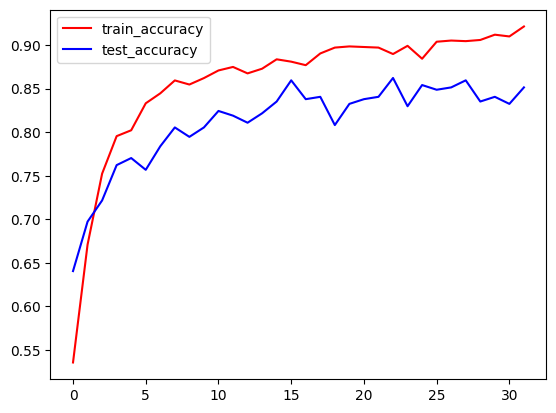

In [10]:
# Visualise train / Valid Accuracy
plt.plot(mobilnet_model_fine_tune.history.history["binary_accuracy"], c="r", label="train_accuracy")
plt.plot(mobilnet_model_fine_tune.history.history["val_binary_accuracy"], c="b", label="test_accuracy")
plt.legend()
plt.show()

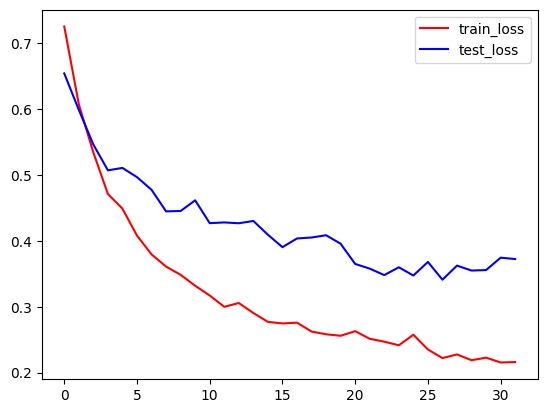

In [11]:
# Visualise train / Valid Accuracy
plt.plot(mobilnet_model_fine_tune.history.history["loss"], c="r", label="train_loss")
plt.plot(mobilnet_model_fine_tune.history.history["val_loss"], c="b", label="test_loss")
plt.legend()
plt.show()

In [12]:
mobilnet_model_fine_tune.save("mobilenetv2model_finetune.h5")

In [13]:
import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = mobilnet_model_fine_tune.history.history
# Save it under the form of a json file
json.dump(history_dict, open("mobilenetv2model_finetune_History.json", 'w'))

In [14]:
moadel_loaded = tf.keras.models.load_model("ckpt_mobilenet/model_epoch_23_val_acc_0.86.h5")

In [15]:
y_pred_test = moadel_loaded.predict(img_generator_flow_valid)
y_pred_test = (y_pred_test > 0.5).astype(int).flatten()  # Convertion in 0/1


24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 746ms/step


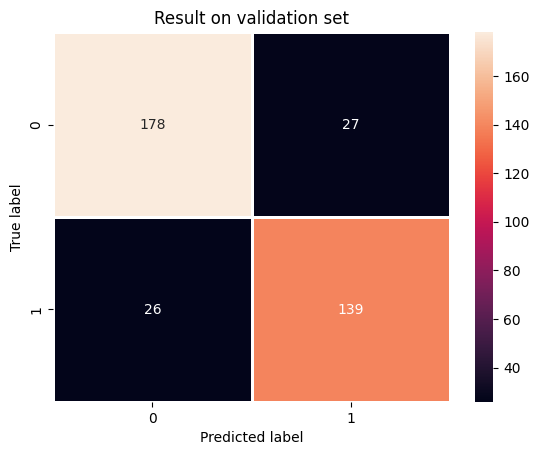

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mtx = confusion_matrix(img_generator_flow_valid.classes, y_pred_test)
sns.heatmap(mtx, annot=True, fmt='d', linewidths=.8)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Result on validation set')
plt.show()
